# Первая часть

Нам нужно было с чего-то начать.  

**Первая идея** - определить где находится рельс и искать в нем вертикальную линию - сам рельс.  
А потом искать перпендикулярные к нему линии - зазоры, и определять их ширину.


Для работы воспользовались следующими библиотеками:  
* opencv - для чтения видео, разных фильтров, потом и линии с ее помощью стали искать
* pylsd-nova - определение в кадре линий
* pytesseract - определение текста в картинке (требуется установка программы Tesseract-OCR)

In [9]:
#!pip install opencv-python
#!pip install pylsd-nova
#!pip install pytesseract


In [10]:
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pylsd.lsd import lsd
import pytesseract

from sklearn.metrics.pairwise import manhattan_distances
from IPython.display import clear_output



**Настройки блокнота**

In [11]:
plt.rcParams["figure.figsize"] = [16,9] # Увеличим габариты вывода рисунков

DATA = "../data/CAM0.avi" # путь до файла с видео

# Получаем кадры из видео

С помощью opencv разбивать avi файл на картинки достаточно просто.  
Также сделаем преобразование в серые оттенки, т.к. дальнейшие алгоритмы требуют такого формата картинки.  
Покажем также что картинка это просто np.array, преобразование в серый просто схлопывает 3 измерения цвета в 1 число.

In [17]:
cap = cv2.VideoCapture(DATA)

In [18]:
def show_frame(frame):
    plt.imshow(frame, cmap='gray')
    plt.show()

Цветная картинка это <class 'numpy.ndarray'> (720, 1024, 3)
Серая картинка это <class 'numpy.ndarray'> (720, 1024)


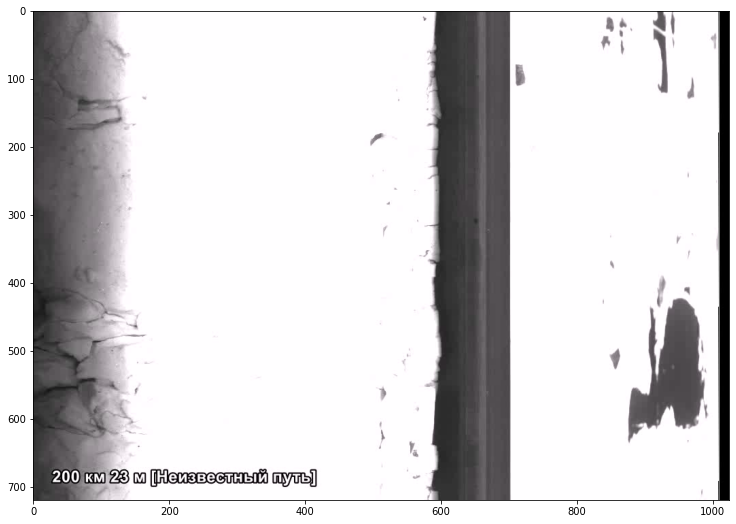

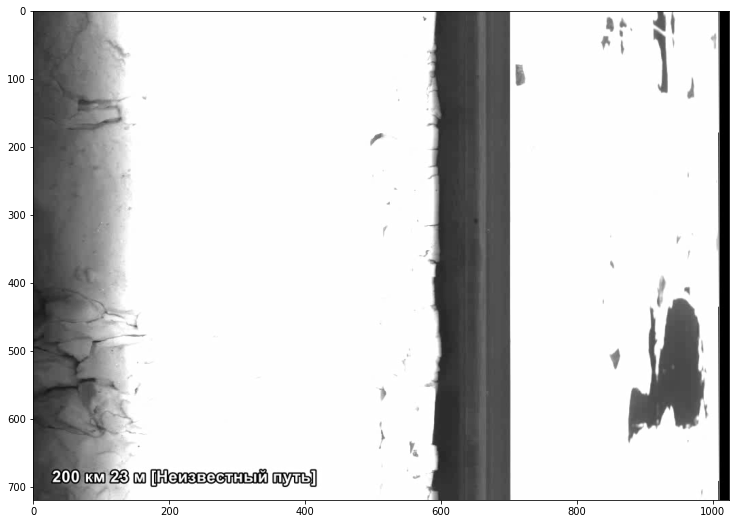

In [19]:
_, rgb_frame = cap.read()

gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2GRAY) # Преобразуем в серую палитру

print(f"Цветная картинка это {type(rgb_frame)} {rgb_frame.shape}")
print(f"Серая картинка это {type(gray_frame)} {gray_frame.shape}")

show_frame(rgb_frame)
show_frame(gray_frame)


# Бинаризация картинки и поиск границ Canny 

C помощью трех функций opencv сделаем из картинки (массива) _представление_ показывающее границы на рисунке:  
* GaussianBlur - размытие, чтобы убрать мелкий шум
* threshold - бинаризация (оставить черное и белое)
* Canny - ищет границу между черным и белым

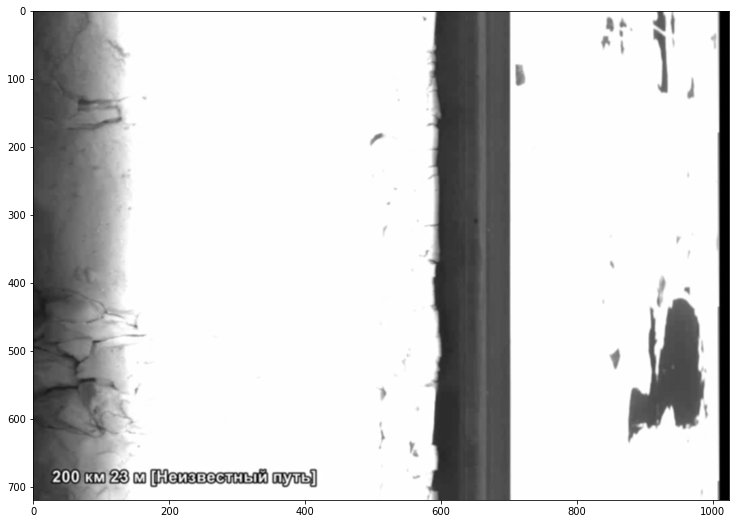

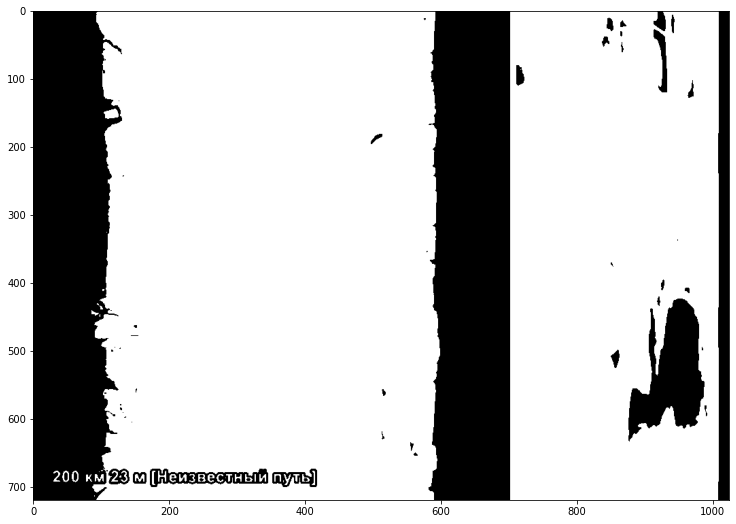

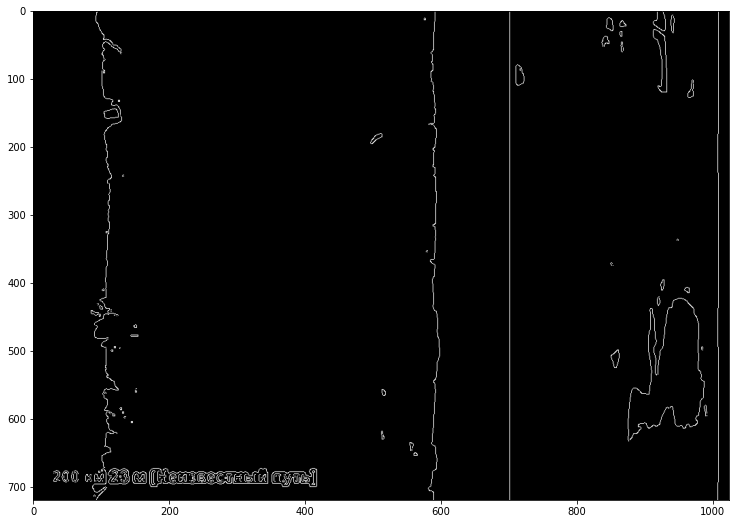

In [8]:
# размыливаем изображение
blur_frame = cv2.GaussianBlur(gray_frame, (3, 3), 2)

# делаем бинаризацию (все что больше 170 - белое, остальное черное)
_, thresh_frme = cv2.threshold(blur_frame, 170, 255, 0)

# ищем границы черного и белого методом Canny
edged_frame = cv2.Canny(thresh_frme, 100, 250)

show_frame(blur_frame)
show_frame(thresh_frme)
show_frame(edged_frame)

обернем это в функцию

In [24]:
def get_edges_frame(gray_frame):
    """
    Преобразует переденное серое изображение в картинку, где остались только белые границы на черном фоне
    """
    # размыливаем изображение
    blur_frame = cv2.GaussianBlur(
        gray_frame, (3, 3), 2)

    # делаем бинаризацию (все что больше 170 - белое, остальное черное)
    _, thresh_frme = cv2.threshold(blur_frame, 170, 255, 0)

    # ищем границы черного и белого методом Canny
    edged_frame = cv2.Canny(thresh_frme, 100, 250)

    return edged_frame

# Пытаемся найти где же стык двух рельс

На этом этапе мы сделали серъезное допущение.  
**ДОПУЩЕНИЕ:** камера у нас фиксированная и мы можем жестко указать рамку, в которой будет рельс.

In [20]:
START_BORDER, END_BORDER = 625, 725

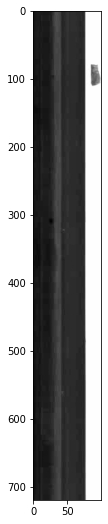

In [21]:
show_frame(gray_frame[:, START_BORDER:END_BORDER])

## Функция для поиска линий в кадре (Кирилл)

Этот алгоритм ищет линии на кадре с помощью библиотеки lsd.

Далее пытается их укрупнить, потому что находит много мелкию линий (смещение в пару пикселей - уже делает разрыв линии).  
И оставляет только те линии, у которыю угол меньше 5 градусов.

In [25]:
def get_angle_of_line_between_two_points(y1, y2):
    """
    функция, вроде бы должна определять угол линии между двумя точкми, но получает только две координаты y
    """
    return abs(math.degrees(math.atan2(y2 - y1, 1)))


def find_line_segment(edged_frame):
    """
    функция возвращет координаты интересных нам линий на переданном фрагменте
    """
    lines = lsd(edged_frame, scale=1)  # ищет все линии на переданном сегменте

    # в lines - массивы из 5 элементов (y1,x1,y2,x2,width)

    lines = lines[:, :-1]  # удаляем толщину линии
    lines = lines.astype(int)  # преобразуем в int
    lines[lines > 690] = 720  # обрезаем крайние координаты
    lines[lines < 30] = 0

    # какие-то хитрые действия
    lines[:, [0, 2]] = int(lines[:, [0, 2]].mean())
    lines[:, (1, 3)] = np.sort(lines[:, (1, 3)], axis=1)
    lines = lines[np.argsort(lines[:, 1])]

    # и еще несколько хитрых действий
    d = manhattan_distances(lines)
    lines = lines[~np.any(np.tril(d < 2, -1), axis=0)]

    line_buffer = None
    correct_lines = []
    for line in lines:
        start_point = line[0], line[1]
        end_poing = line[2], line[3]

        if get_angle_of_line_between_two_points(start_point[0], end_poing[0]) < 5:
            # если угол менье 5 градусов

            if line_buffer is not None:
                if 10 < (start_point[1] - line_buffer[3]) < 75:
                    correct_lines.append(
                        ((0, line_buffer[3]), (1024, line_buffer[3])))
                    correct_lines.append(
                        ((0, start_point[1]), (1024, start_point[1])))

            line_buffer = line.copy()
            correct_lines.append(
                ((start_point[0]+START_BORDER, start_point[1]), (end_poing[0]+START_BORDER, end_poing[1])))

    return correct_lines

Пример работы на одном кадре

In [26]:
edged_cut_frame = get_edges_frame(gray_frame[:, START_BORDER:END_BORDER])
find_line_segment(edged_cut_frame)

[((708, 0), (708, 720)),
 ((708, 81), (708, 106)),
 ((708, 83), (708, 105)),
 ((708, 88), (708, 103))]

Визуальное отображение работы алгоритма. (нажмите **interrupt the kernel** чтобы прервать)

In [27]:
while cap.isOpened():

    ret, rgb_frame = cap.read()
    if not ret:
        print("Видео закончилось. Выходим....")
        break

    gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2GRAY)
    edged_cut_frame = get_edges_frame(gray_frame[:, START_BORDER:END_BORDER])

    lines = find_line_segment(edged_cut_frame)

    for line in lines:
        cv2.line(rgb_frame, line[0], line[1], (255, 0, 0), 3)

    time.sleep(.3)
    show_frame(rgb_frame)
    clear_output(wait=True)
    

KeyboardInterrupt: 

## Второй алгоритм поиска линий (Антон)

Этот алгоритм использует другую функцию поиска линий - встроенную в opencv - *HoughLinesP*

И ищет уже линии между 80 и 90 градусами 

In [28]:
def find_line_segment_2(edged_frame):
    """
    функция возвращет координаты интересных нам линий на переданном фрагменте
    """
    lines = cv2.HoughLinesP(edged_frame, 1, np.pi / 180, 10, None, 10, 20) # Еще один магический способ найти линии
    
    correct_lines = []
    for line in lines:
        start_point = line[0][0], line[0][1]
        end_point = line[0][2], line[0][3]
        angle = get_angle_of_line_between_two_points(start_point[0], end_point[0])
        
        if 80 < angle < 100:
            new_line = ((start_point[0]+START_BORDER, start_point[1]),
                        (end_point[0]+START_BORDER, end_point[1])
                       )
            correct_lines.append(new_line)
    return correct_lines
            

Пример работы на одном кадре

In [29]:
edged_cut_frame = get_edges_frame(gray_frame[:, START_BORDER:END_BORDER])
find_line_segment_2(edged_cut_frame)

[]

Визуальное отображение работы алгоритма

In [30]:
while cap.isOpened():

    ret, rgb_frame = cap.read()
    if not ret:
        print("Видео закончилось. Выходим....")
        break

    gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2GRAY)
    edged_cut_frame = get_edges_frame(gray_frame[:, START_BORDER:END_BORDER])

    lines = find_line_segment_2(edged_cut_frame)

    if not lines:
        continue
    
    for line in lines:
        cv2.line(rgb_frame, line[0], line[1], (255, 0, 0), 3)

    time.sleep(.3)
    show_frame(rgb_frame)
    clear_output(wait=True)

KeyboardInterrupt: 

## Третий алгоритм поиска (доработанный второй)

Сделаем область поиска еще уже.

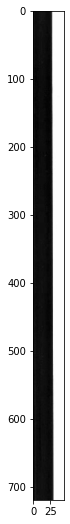

In [31]:
START_BORDER, END_BORDER = 680, 725
show_frame(gray_frame[:, START_BORDER:END_BORDER])

Алгоритм похож на втрой, но для найденной линии мы делаем ее горизонтальной.   

Координаты x начала и конца усредяем. А ширину линии - ограничиваем шириной рамки.

In [32]:
def find_line_segment_3(edged_frame):
    """
    функция возвращет координаты интересных нам линий на переданном фрагменте
    """
    lines = cv2.HoughLinesP(edged_frame, 1, np.pi / 180, 10, None, 10, 20) # Еще один магический способ найти линии
    
    correct_lines = []
    for line in lines:
        start_point = line[0][0], line[0][1]
        end_point = line[0][2], line[0][3]
        angle = get_angle_of_line_between_two_points(start_point[0], end_point[0])
        
        if 80 < angle < 100:
            mean_x = int(np.mean([start_point[1], end_point[1]]))
            new_line = ((START_BORDER, mean_x),
                        (END_BORDER, mean_x)
                       )
            correct_lines.append(new_line)
    return correct_lines
    

In [33]:
while cap.isOpened():

    ret, rgb_frame = cap.read()
    if not ret:
        print("Видео закончилось. Выходим....")
        break

    gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2GRAY)
    edged_cut_frame = get_edges_frame(gray_frame[:, START_BORDER:END_BORDER])

    lines = find_line_segment_3(edged_cut_frame)

    if not lines:
        continue
        
    for line in lines:
        cv2.line(rgb_frame, line[0], line[1], (255, 0, 0), 3)

    time.sleep(.1)
    show_frame(rgb_frame)
    clear_output(wait=True)

KeyboardInterrupt: 

<Figure size 1152x648 with 0 Axes>

# Определяем текст в картинке

Также сделаем допущение что текст у нас всегда в одной области кадра.  
Натравим pytesseract искать текст в этой области.

In [34]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # путь до бинарника для tesseract

In [35]:
def get_numbers_from_image(gray_image):
    text_1 = pytesseract.image_to_string((gray_image < 250),
                                         lang='eng',
                                         config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'
                                         )
    return text_1.strip()

def get_coordinates_of_frame(gray_image):

    text_image_1 = gray_image[-50:-20, 24:75]
    text_image_2 = gray_image[-50:-20, 110:155]
    
    return (
        get_numbers_from_image(text_image_1),
        get_numbers_from_image(text_image_2)
    )
    

('200', '136')


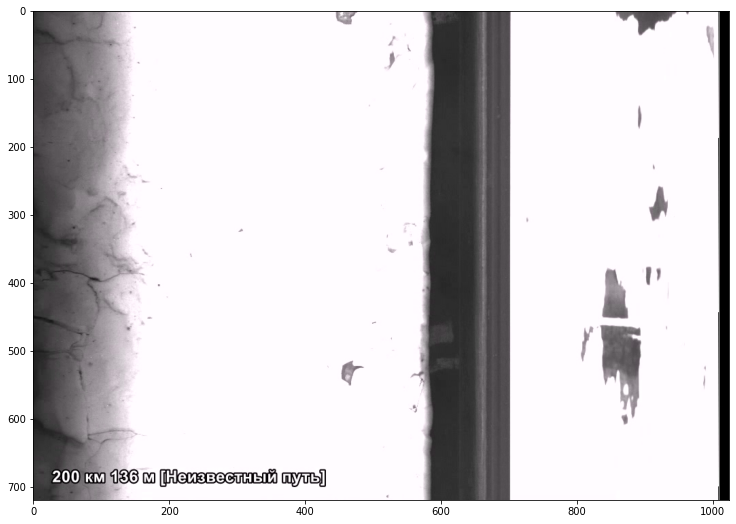

KeyboardInterrupt: 

In [40]:
while cap.isOpened():

    ret, rgb_frame = cap.read()
    if not ret:
        print("Видео закончилось. Выходим....")
        break

    gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2GRAY)
    
    clear_output(wait=True)
    
    print(get_coordinates_of_frame(gray_frame))
    show_frame(rgb_frame)
    time.sleep(.5)
    

# Дополнительные материалы

* [OpenCV — обнаружение острых кромок](https://coderlessons.com/tutorials/akademicheskii/izuchite-opencv/opencv-obnaruzhenie-ostrykh-kromok)
* [Обнаружение объектов с помощью цветовой сегментации изображений в Python](https://medium.com/nuances-of-programming/%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2-%D1%81-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E-%D1%86%D0%B2%D0%B5%D1%82%D0%BE%D0%B2%D0%BE%D0%B9-%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8-%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9-%D0%B2-python-9128814bc55c)
* [Hough Line Transform](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)